In [23]:
import torch
import torch.nn as nn
import torch_geometric.utils as utils
import torch_geometric.data
from torch_geometric.nn.models import GAE
from torch_geometric.nn import GCNConv
import networkx as nx
import numpy as np
import pickle

# pre-training GAE

用 3 层 GCNConv ，`weight_decay` 需要比 2 层 GCNConv 小一个数量级。
比如 2 层 `5e-4`，3 层则为 `5e-5`

In [55]:
class gae_encoder(nn.Module):
    def __init__(self, in_features: int, out_features: int, hidden_1: int,hidden_2:int) -> None:
        super().__init__()
        self.conv1 = GCNConv(in_features, hidden_1)
        self.conv2 = GCNConv(hidden_1, hidden_2)
        self.conv3 = GCNConv(hidden_2,out_features)

    def forward(self, data: torch_geometric.data.Data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x,edge_index)
        x = nn.functional.relu(x)
        x = self.conv2(x,edge_index)
        x = nn.functional.relu(x)
        return self.conv3(x,edge_index)

# Dolphin

In [135]:
G1 = nx.read_adjlist('../dataset/dolphins.mtx', nodetype=int)
dol_data = utils.from_networkx(G1)
dol_data

Data(edge_index=[2, 318], num_nodes=62)

## using eye matrix as feature

In [136]:
x = torch.eye(nx.number_of_nodes(G1))
dol_data.x = x
dol_data

Data(edge_index=[2, 318], num_nodes=62, x=[62, 62])

In [137]:
gae_model = GAE(gae_encoder(G1.number_of_nodes(),32,64,64),)
optimizer = torch.optim.Adam(gae_model.parameters(),lr=0.001,weight_decay=5e-5)

## Train GAE

In [139]:
for epoch in range(1000):
    optimizer.zero_grad()
    loss = gae_model.recon_loss(gae_model(dol_data),dol_data.edge_index)
    loss.backward()
    optimizer.step()
    print(f"epoch:{epoch}, loss: {loss.item():.4f}\r",end='')

## Test GAE

In [140]:
z = gae_model(dol_data)
gae_model.test(z,dol_data.edge_index,utils.negative_sampling(dol_data.edge_index,))

(0.9734978837862427, 0.971586043948092)

## Draw

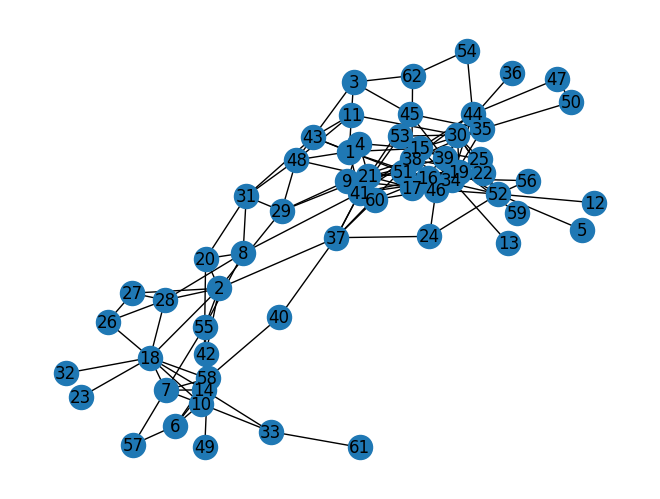

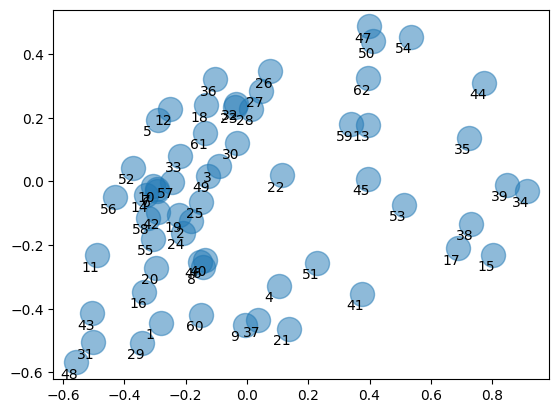

In [141]:
import matplotlib.pyplot as plt

dol_embeddings = utils.get_embeddings(gae_model,dol_data)
dol_embeddings = np.array(dol_embeddings[2])

annotation = []
axis_x = []
axis_y = []
for value in dol_embeddings:
    axis_x.append(value[0])
    axis_y.append(value[1])

nx.draw(G1,with_labels=True,pos=nx.spring_layout(G1,seed=0))
fig,ax = plt.subplots()
ax.scatter(axis_x,axis_y,s=300,alpha=0.5)
for i,t in enumerate(G1.nodes()):
    ax.annotate(t,xy=(axis_x[i],axis_y[i]),xytext=(axis_x[i]-0.05,axis_y[i]-0.05))
plt.show()

## Save model

In [142]:
torch.save(gae_model.state_dict(),'pre_trained_GAE_emb/model_weight/dol_gae.pkl')
emb = utils.get_embeddings(gae_model,dol_data)[2]
with open('pre_trained_GAE_emb/dol_pretrained_emb','wb') as f:
    pickle.dump(emb,f)

## Load Model

In [6]:
model = GAE(gae_encoder(G1.number_of_nodes(),32,64),)
model.load_state_dict(torch.load('./dol_gae.pkl',))

<All keys matched successfully>

In [7]:
emb = model(dol_data)

In [9]:
emb.shape

torch.Size([62, 32])

# Food

In [125]:
G2 = nx.read_adjlist('../dataset/fb-pages-food.txt', nodetype=int, delimiter=',')
food_data = utils.from_networkx(G2)
food_data

Data(edge_index=[2, 4193], num_nodes=620)

In [126]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [127]:
x = torch.eye(nx.number_of_nodes(G2),device=device)
food_data.x = x
food_data.edge_index=food_data.edge_index.to(device)
food_data.edge_index

tensor([[  0,   0,   0,  ..., 618, 619, 619],
        [  1,   2,   3,  ...,  89,  89, 619]], device='cuda:0')

In [130]:
gae_model = GAE(gae_encoder(G2.number_of_nodes(),32,128,128),).to(device)
optimizer = torch.optim.Adam(gae_model.parameters(),lr=0.001,weight_decay=5e-5)

In [131]:
for epoch in range(1000):
    optimizer.zero_grad()
    loss = gae_model.recon_loss(gae_model(food_data),food_data.edge_index)
    loss.backward()
    optimizer.step()
    print(f"epoch:{epoch}, loss: {loss.item():.4f}\r",end='')

In [132]:
z = gae_model(food_data)
gae_model.test(z,food_data.edge_index,utils.negative_sampling(food_data.edge_index,))

(0.9888656374754717, 0.9860594442406303)

In [133]:
torch.save(gae_model.state_dict(),'pre_trained_GAE_emb/model_weight/food_gae.pkl')

In [134]:
emb = utils.get_embeddings(gae_model,food_data)[2]
with open('pre_trained_GAE_emb/food_pretrained_emb','wb') as f:
    pickle.dump(emb,f)

# netSci

In [114]:
G3 = nx.read_adjlist('../dataset/trimed_netScience.csv', nodetype=int, delimiter=',')
netsci_data = utils.from_networkx(G3)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

x = torch.eye(nx.number_of_nodes(G3),device=device)
netsci_data.x = x
netsci_data.edge_index=netsci_data.edge_index.to(device)
netsci_data.edge_index

tensor([[   0,    0,    0,  ..., 1459, 1459, 1460],
        [   1,    3,    2,  ..., 1458, 1460, 1459]], device='cuda:0')

In [121]:
gae_model = GAE(gae_encoder(G3.number_of_nodes(),32,256,128),).to(device)
optimizer = torch.optim.Adam(gae_model.parameters(),lr=0.003,weight_decay=5e-5)

In [122]:
for epoch in range(1,1001):
    optimizer.zero_grad()
    loss = gae_model.recon_loss(gae_model(netsci_data),netsci_data.edge_index)
    loss.backward()
    optimizer.step()
    print(f"epoch:{epoch}, loss: {loss.item()}\r",end='')

In [123]:
z = gae_model(netsci_data)
gae_model.test(z,netsci_data.edge_index,utils.negative_sampling(netsci_data.edge_index,))

(0.9952468317088209, 0.9927557437160686)

In [124]:
torch.save(gae_model.state_dict(),'pre_trained_GAE_emb/model_weight/netsci_gae.pkl')
emb = utils.get_embeddings(gae_model,netsci_data)[2]
with open('pre_trained_GAE_emb/netsci_pretrained_emb','wb') as f:
    pickle.dump(emb,f)

# USpower

In [143]:
G4 = nx.read_adjlist('../dataset/USpowerGrid.mtx', nodetype=int,)
uspower_data = utils.from_networkx(G4)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

x = torch.eye(nx.number_of_nodes(G4),device=device)
uspower_data.x = x
uspower_data.edge_index=uspower_data.edge_index.to(device)
uspower_data.edge_index

tensor([[   0,    0,    0,  ..., 4939, 4939, 4940],
        [   1, 3680, 3643,  ...,  916, 4938, 4933]], device='cuda:0')

In [144]:
gae_model = GAE(gae_encoder(G4.number_of_nodes(),32,256,256),).to(device)
optimizer = torch.optim.Adam(gae_model.parameters(),lr=0.003,weight_decay=5e-5)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,[100,200,500,600],0.1)

In [145]:
for epoch in range(1,1001):
    optimizer.zero_grad()
    loss = gae_model.recon_loss(gae_model(uspower_data),uspower_data.edge_index)
    loss.backward()
    optimizer.step()
    # scheduler.step()
    print(f"epoch:{epoch}, loss: {loss.item():.4f}\r",end='')

In [146]:
z = gae_model(uspower_data)
gae_model.test(z,uspower_data.edge_index,utils.negative_sampling(uspower_data.edge_index,))

(0.9845516424753195, 0.9757623857733506)

In [147]:
torch.save(gae_model.state_dict(),'pre_trained_GAE_emb/model_weight/uspower_gae.pkl')
emb = utils.get_embeddings(gae_model,uspower_data)[2]
with open('pre_trained_GAE_emb/uspower_pretrained_emb','wb') as f:
    pickle.dump(emb,f)